In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import *
from scipy.stats import chi2
from ExternalFunctions import nice_string_output, add_text_to_ax

# Problem Setup and Data Loading
This section loads the Mössbauer spectroscopic data and sets up initial parameters.

In [12]:
data = np.loadtxt('mars_soil.txt')

z_obs = data[:, 0]
d_obs = np.max(data[:, 1]) - np.array(data[:, 1])

N = len(d_obs)

# Cases

In [ ]:
#Set to True for Gaussian case, or False for Lorentzian case
case = False

# Initialization and Functions

In [14]:
def get_initial_data():

    h = np.array([1600, 4400, 4500, 1550, 2800, 3550, 4100,  1800, 3950, 1700, 1700, 4100, 2050, 4300, 3450, 2900, 1500, 4450, 4550, 1900])    
    f = np.array([-10.4, -8.8, -7.6, -7.1, -6.4, -5.7, -4.4, -3.7, -3., -1.8, 1.8,  3.1,  3.7,  4.2,  5.4,  6.4,  7,  7.4,  8.8,  10.5])
    c = np.array([1.6,  1.4,  1,  0.5,  0.6,  0.9,  0.9,  0.5,  0.9,  0.9,  0.9,  0.9,  0.6,  0.6,  1,  0.4,  0.2,  0.8,  1.3,  1.6])
    
    c = c/10
    if case:
        A = h*c*np.sqrt(2*np.pi)
    else:
        A = h
        
    q = len(A)

    return A, f, c, h, q

def create_m(A_i, f_i, c_i):
    matrix=[]
    for i in range(len(A_i)):
        matrix.append(A_i[i])
        matrix.append(f_i[i])
        matrix.append(c_i[i])
    return matrix

def reduce_m(matrix):
    A, f, c = matrix[::3], matrix[1::3], matrix[2::3]
    return A, f, c


In [15]:
####Initialize m####
A_initial, f_initial, c_initial, h_initial, q= get_initial_data()
m_prior = create_m(A_initial, f_initial, c_initial)

In [16]:
####Constructing G####
def G_k(N, q, m, z, case):
    G = np.zeros((N, 3*q))
    A, f, c = reduce_m(m)
    if case:
        for j in range(q):
            dg_dAj = 1/(np.sqrt(2*np.pi)*c[j])*np.exp(-(z-f[j])**2/(2*c[j]**2))
            dg_dfj = A[j]*(z-f[j])/np.sqrt(2*np.pi)/c[j]**3*np.exp(-(z-f[j])**2/(2*c[j]**2))
            dg_dcj = A[j]/np.sqrt(2*np.pi)*((z-f[j])**2-c[j]**2)/c[j]**4*np.exp(-(z-f[j])**2/(2*c[j]**2))

            G[:, j*3]     = dg_dAj
            G[:, j*3 + 1] = dg_dfj
            G[:, j*3 + 2] = dg_dcj
            
    else:   
        for j in range(q):
            dg_dAj = c[j]**2/(c[j]**2+(z-f[j])**2)
            dg_dfj = 2*A[j]*c[j]**2*(z-f[j])/(c[j]**2+(z-f[j])**2)**2
            dg_dcj = 2*A[j]*c[j]*(z-f[j])**2/(c[j]**2+(z-f[j])**2)**2

            G[:, j*3]     = dg_dAj
            G[:, j*3 + 1] = dg_dfj
            G[:, j*3 + 2] = dg_dcj
    return G


In [17]:
####Setting up steepest descent####
def invC_d(N):
    sigmas = [300**2]*N
    Cd = np.linalg.inv(np.diag(sigmas))
    return Cd

def C_m(q):
    sA = 1000.
    sf = 1.2
    sc = 0.08 
    sigmas = ([sA, sf, sc]*q)
    Cm = np.diag(sigmas)**2
    return Cm

def Gaussian(Ag, fg, cg, z):
    return Ag/(np.sqrt(2*np.pi)*cg)*np.exp(-(z-fg)**2/(2*cg**2))

def Lorentzian(Al, fl, cl, z):
    return Al*cl**2/((z-fl)**2 + cl**2)

def g_k(m, z_obs, case):
    A, f, c = reduce_m(m)
    g = []
    if case:
        for z in z_obs:
            g.append(np.sum(Gaussian(A, f, c, z)))
    else:
        for z in z_obs:
            g.append(np.sum(Lorentzian(A, f, c, z)))
    return np.array(g).T

def gamma_k(m, m_prior, d_obs, G, g, Cm):
    return Cm@G.T@invC_d(N)@(g - d_obs.T) + (m - m_prior)

def epsilon_k(gam, G, Cm):
    num = gam.T@np.linalg.inv(Cm)@gam
    denom = gam.T@(G.T@invC_d(N)@G+np.linalg.inv(Cm))@gam
    epsilon = num/denom
    return epsilon

# Steepest Descent Algorithm
Implement the iterative algorithm to minimize the data misfit and regularization term, updating the model parameters at each step.

In [18]:
###Steepest descent algorithm###
N_t = 1000
m_k = np.copy(m_prior)

for i in tqdm(range(N_t)):
    Cm = C_m(q)
    G = G_k(N, q, m_k, z_obs.copy(), case) 
    g = g_k(m_k, z_obs, case)
    gam = gamma_k(m_k, m_prior, d_obs, G, g, Cm)
    eps = epsilon_k(gam, G, Cm)

    m_k = m_k - eps * gam

100%|██████████| 1000/1000 [00:49<00:00, 20.32it/s]


# Visualization

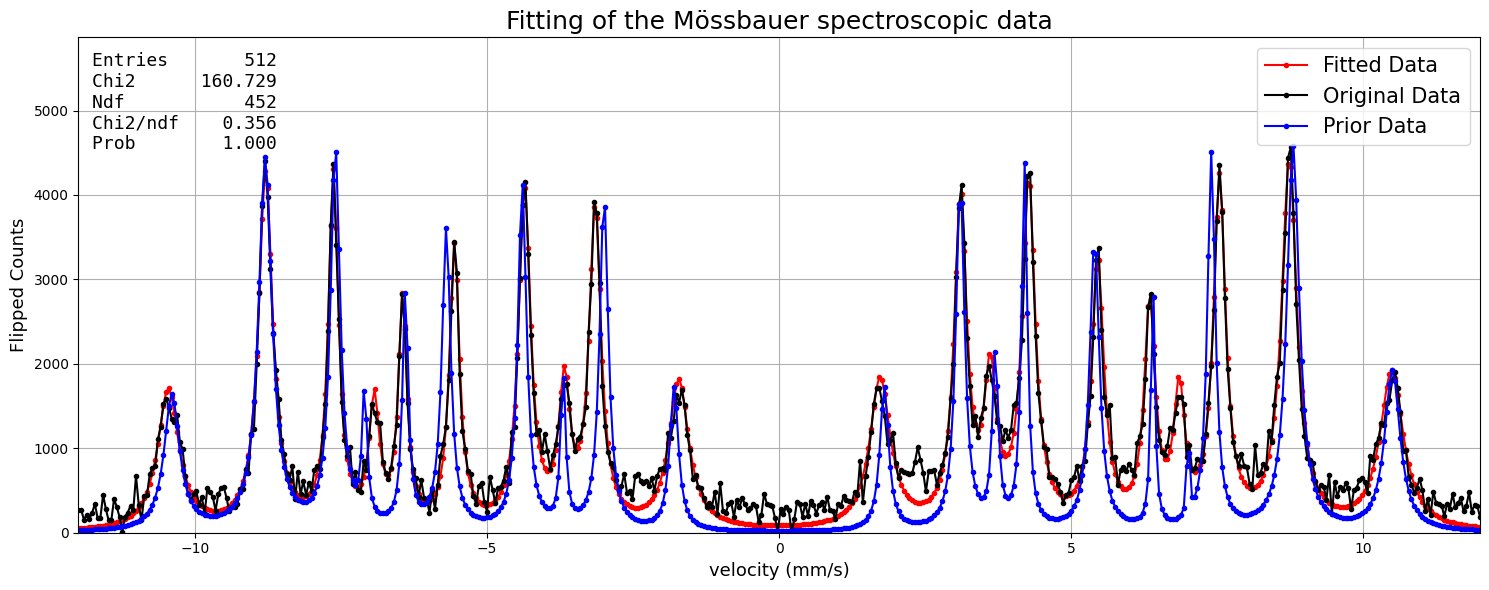

In [19]:
#####Visualization#####
fig, ax = plt.subplots(figsize = (15, 6))
if case:
    dGauss = g_k(m_k, z_obs, case)
    ax.plot(z_obs, dGauss, '-o', label ='Fitted Data', color = 'r', markersize = 3)
    
    Chi2 = np.sum(((dGauss - d_obs)/(300))**2)
    Ndof = d_obs.shape[0] - m_k.shape[0]
    Prob_fit = chi2.sf(Chi2, Ndof)
    reduced_chi2 = Chi2 / Ndof

else:
    dLorentz = g_k(m_k, z_obs, case)
    ax.plot(z_obs, dLorentz, '-o', label ='Fitted Data', color = 'r', markersize = 3)
    Chi2 = np.sum(((dLorentz - d_obs)/(300))**2)
    Ndof = d_obs.shape[0] - m_k.shape[0]
    Prob_fit = chi2.sf(Chi2, Ndof)
    reduced_chi2 = Chi2 / Ndof

ax.plot(z_obs, d_obs, '-o', label = 'Original Data', color = 'k', markersize = 3)
ax.plot(z_obs, g_k(np.array(m_prior), z_obs, case), '-o', label = 'Prior Data', color = 'b', markersize = 3)
ax.set_ylabel('Flipped Counts', fontsize = 13)
ax.set_xlabel('velocity (mm/s)', fontsize = 13)
ax.set_xlim([-12, 12])
ax.set_ylim([0, max(d_obs) + 1300])
ax.set_title('Fitting of the Mössbauer spectroscopic data', fontsize = 18)
ax.legend(fontsize = 15)

d = {'Entries' : d_obs.shape[0],
         'Chi2': Chi2,
         'Ndf':      Ndof,
         'Chi2/ndf': reduced_chi2,
         'Prob': Prob_fit,
    }

text = nice_string_output(d, extra_spacing=2, decimals=3)
add_text_to_ax(0.01, 0.97, text, ax, fontsize=13)

fig.tight_layout()
plt.grid()
plt.show()